# Import

## Modules

In [164]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
from datetime import timedelta
import arviz as az
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


In [212]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
sns.set_palette("deep")

 Setup path

In [53]:
PROJECT_ROOT = Path.cwd().parent.resolve()
sys.path.append(str(PROJECT_ROOT))

## Scripts

In [54]:
from src.data.make_dataset import get_cases_data, to_datetime, subset_latest_outbreak, get_daily_cases_stats

## Data

In [55]:
raw_cases_data = get_cases_data()

## Audit

In [56]:
raw_cases_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9171 entries, 0 to 9170
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   notification_date           9171 non-null   object 
 1   postcode                    8376 non-null   object 
 2   likely_source_of_infection  9171 non-null   object 
 3   lhd_2010_code               8365 non-null   object 
 4   lhd_2010_name               8365 non-null   object 
 5   lga_code19                  8365 non-null   float64
 6   lga_name19                  8365 non-null   object 
dtypes: float64(1), object(6)
memory usage: 501.7+ KB


In [57]:
raw_cases_data.head()

,notification_date,postcode,likely_source_of_infection,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19
0,2020-01-25,2134,Overseas,X700,Sydney,11300.0,Burwood (A)
1,2020-01-25,2121,Overseas,X760,Northern Sydney,16260.0,Parramatta (C)
2,2020-01-25,2071,Overseas,X760,Northern Sydney,14500.0,Ku-ring-gai (A)
3,2020-01-27,2033,Overseas,X720,South Eastern Sydney,16550.0,Randwick (C)
4,2020-03-01,2077,Overseas,X760,Northern Sydney,14000.0,Hornsby (A)


# Preprocess data

In [58]:
raw_cases_data = to_datetime('notification_date', raw_cases_data)
data = subset_latest_outbreak('2021-06-01', 'Overseas', raw_cases_data)

In [59]:
data = get_daily_cases_stats(data)

In [151]:
mask = data['Epidemiological Days'] == 0
initial_number_of_cases = data.loc[mask, 'Cumsum'].values[0]
print(f"Initial number of cases: {initial_number_of_cases}")

mask = data['Epidemiological Days'] >= 0
X = data.loc[mask, ["Epidemiological Days", 'Daily Number of Cases', 'Growth Factor']]
y = data.loc[mask, "Weekly Rolling Average"]

Initial number of cases: 92


# Model Training

## Data Preparation

In [258]:
train_size = 0.7
X_train = X.head(round(len(X)*train_size))
X_test = X.tail(round(len(X)*(1-train_size)))
y_train = y.head(round(len(X)*train_size))
y_test = y.tail(round(len(X)*(1-train_size)))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

daily_number_of_cases_std = X_train['Daily Number of Cases'].std()
average_growth_factor = X_train['Growth Factor'].mean()
std_growth_factor = X_train['Growth Factor'].std()

X_train = X_train["Epidemiological Days"].values
y_train = y_train.values
X_test = X_test["Epidemiological Days"].values
y_test = y_test.values

X = X["Epidemiological Days"].values
y = y.values

## Training

In [249]:
# Create PyMC3 context manager
with pm.Model() as model:
    t = pm.Data("X", X_train)
    cases = pm.Data("y", y_train)

    # Intercept - We fixed this at 100.
    a = pm.Normal("a", mu=initial_number_of_cases, sigma=daily_number_of_cases_std)

    # Slope - Growth rate: 0.2 is approx value reported by others
    b = pm.Normal("b", mu=average_growth_factor, sigma=std_growth_factor)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)
    # pm.Poisson("cases", mu=growth, observed=cases)

    trace = pm.sample(1000, tune=1000, cores=5, return_inferencedata=True)
    post_Pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [eps, b, a]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8909337770673282, but should be close to 0.8. Try to increase the number of tuning steps.


## Model Evaluation

In [250]:
# Update data reference.
pm.set_data({"X": X_test}, model=model)

# Generate posterior samples
post_pred_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)


/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [251]:
def hausdorff(y_pred, y_std, y):
    """
    Compute the Hausdorff distance between the predicted and true values.

    Parameters:
    ----------- 
    y_pred: Numpy array. Predicted value. 
    y_std: Numpy array. Standard deviation of the predicted value.
    y: Numpy array. True value.

    Returns:
    --------
    hausdorff_distance: Numpy array. Hausdorff distance between the predicted and true values.
    """
    assert y_pred.shape == y.shape, "The shapes of the predicted and true values do not match."
    assert y_pred.shape == y_std.shape, "The shapes of predicted and std values do not match."

    d = []
    for i in range(y_pred.shape[0]):
        if y_pred[i] - y_std[i] <= y[i] <= y_pred[i] + y_std[i]:
            d.append(0)
        
        elif y[i] < y_pred[i] - y_std[i]:
            d.append(y[i] - (y_pred[i] - y_std[i]))

        else:
            d.append(y[i] - (y_pred[i] + y_std[i]))

    return np.array(d)

In [252]:
# References
# ----------[1] https://stats.stackexchange.com/questions/413209/is-there-something-like-a-root-mean-square-relative-error-rmsre-or-what-is-t

y_pred = np.mean(post_pred_test["cases"].T, axis=1)
y_std = np.std(post_pred_test["cases"].T, axis=1)

sst = np.var(y)
ssr = np.sum((hausdorff(y_pred, y_std, y_test))**2)
r2 = 1 - (ssr/sst)

rmse = np.sqrt((hausdorff(y_pred, y_std, y_test)**2).mean())
rmsre = np.sqrt((hausdorff(y_pred, y_std, y_test)**2 / y_test**2).mean()) # Root Mean Squared Relative Error [%]
rrmse = np.sqrt((hausdorff(y_pred, y_std, y_test)**2).mean() / (y_test**2).sum()) # Root Relative Mean Squared Error
mae = abs(hausdorff(y_pred, y_std, y_test)).mean()
rmae = abs(hausdorff(y_pred, y_std, y_test) / y_test).mean()
print(f"R2 = {r2}")
print(f"RMSE = {rmse}, RMSRE = {rmsre}, RRMSE = {rrmse}")
print(f"MAE = {mae}, Relative MAE = {rmae}")

R2 = 0.9234507610342112
RMSE = 4.472799938670522, RMSRE = 0.0423765304474163, RRMSE = 0.01050450423326804
MAE = 2.247254174429878, Relative MAE = 0.02256013804383687


/home/vscode/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


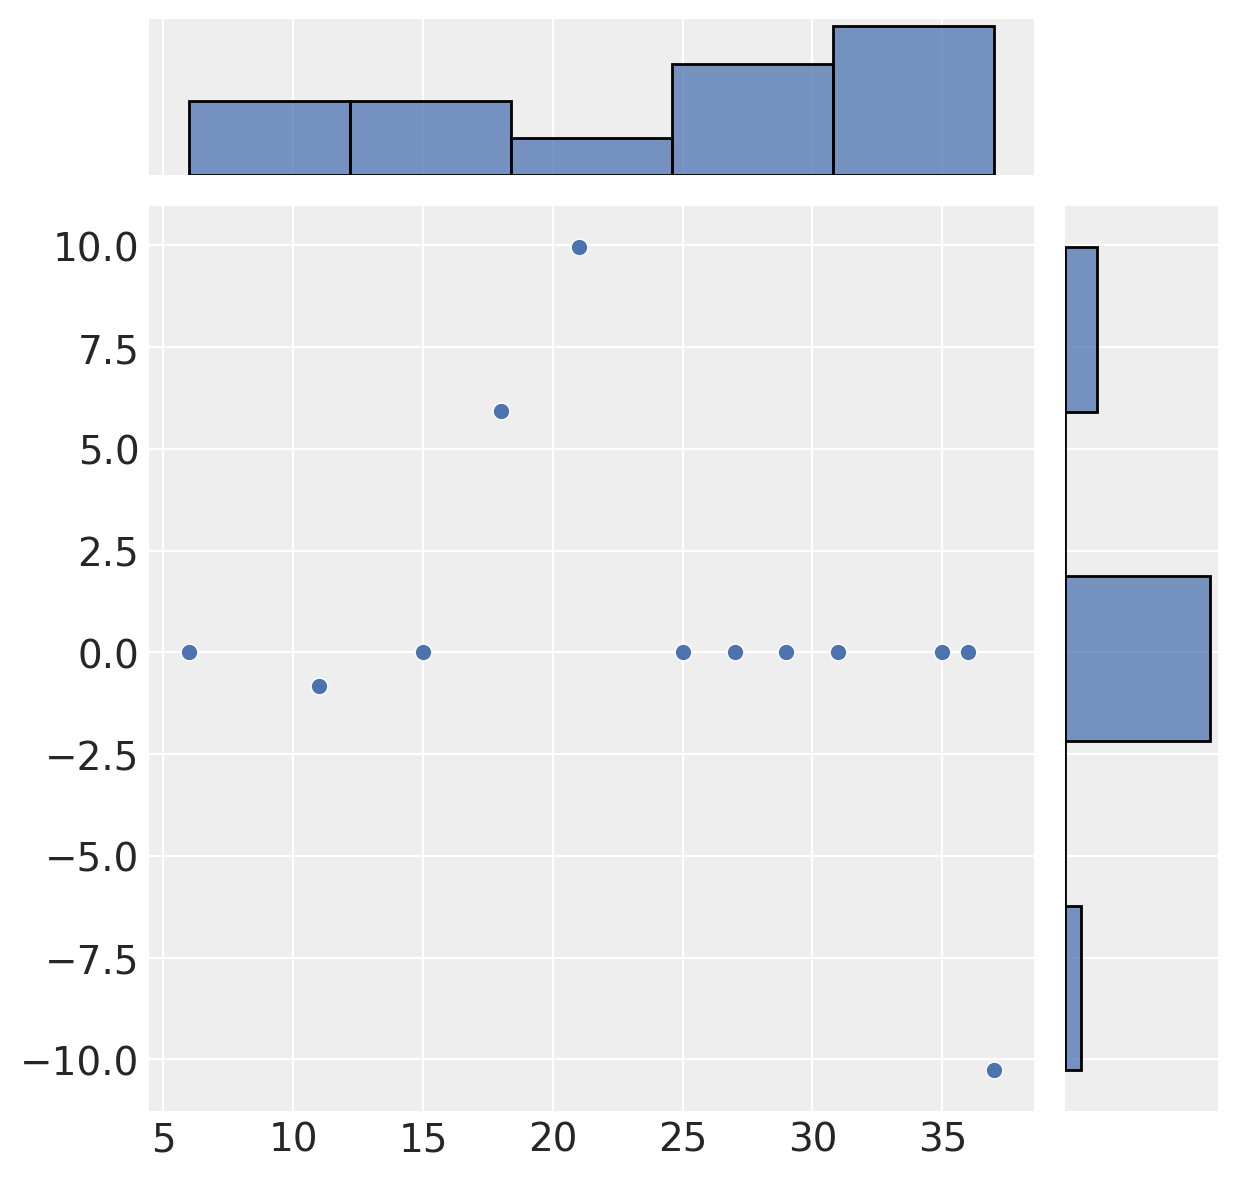

In [253]:
sns.jointplot(x=X_test, y=hausdorff(y_pred, y_std, y_test), ax=ax, marker="o")

# Model Inference

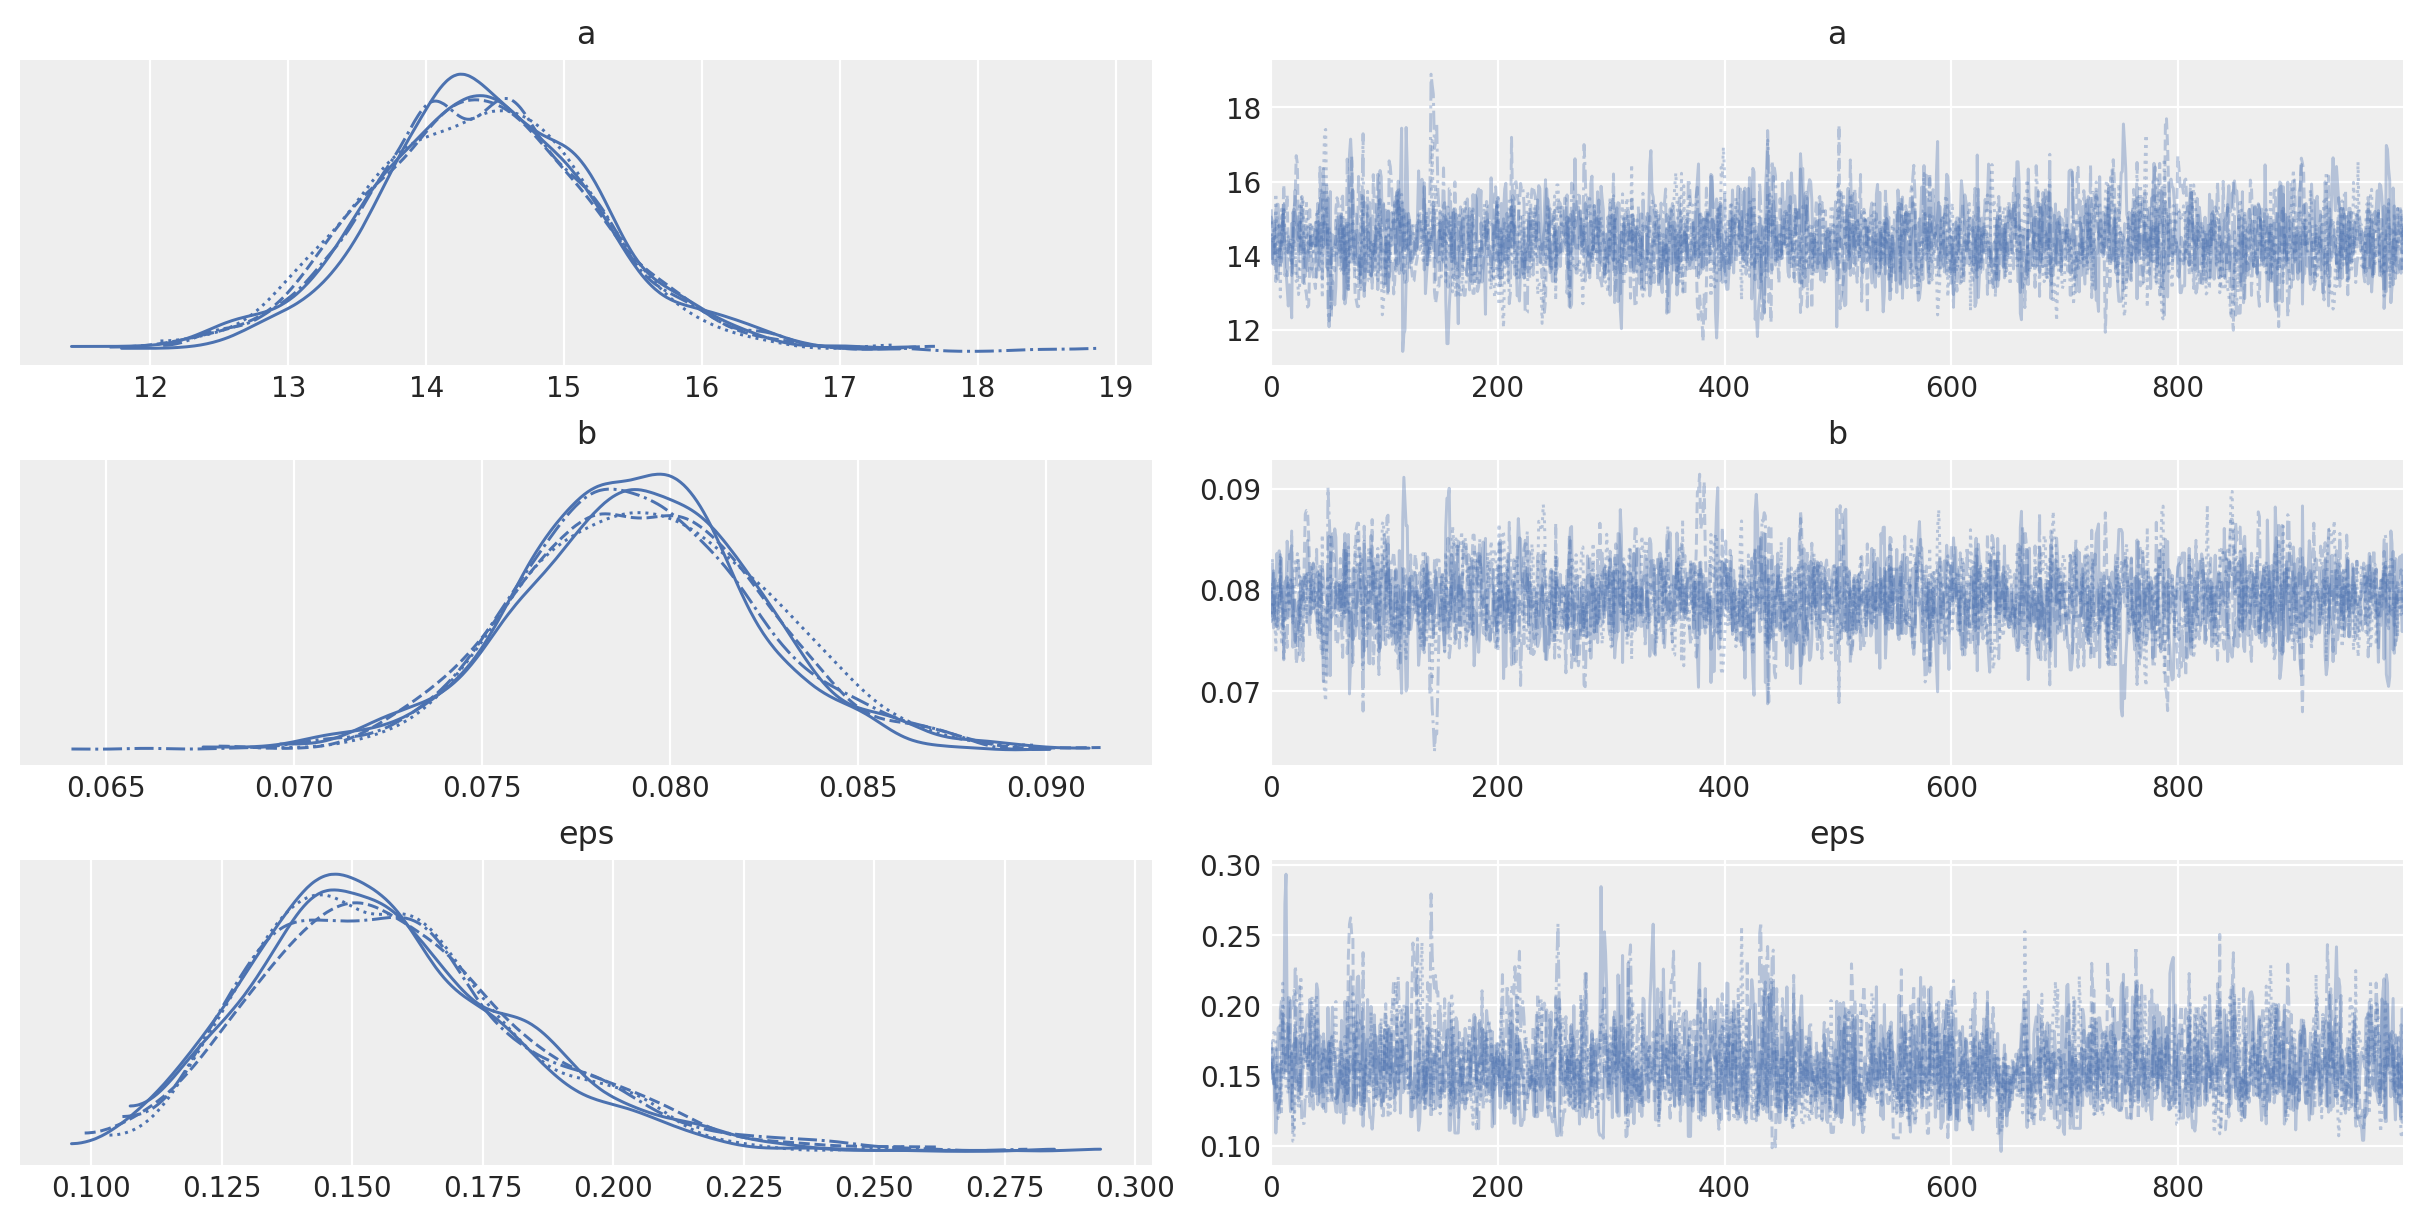

In [254]:
az.plot_trace(trace)
plt.show()

In [255]:
pm.summary(trace).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,14.412,0.837,12.883,16.035,0.019,0.014,1975.0,2244.0,1.0
b,0.079,0.003,0.073,0.085,0.000,0.000,1993.0,2235.0,1.0
eps,0.157,0.025,0.115,0.207,0.001,0.000,2026.0,1860.0,1.0


In [260]:
# Update data reference.
pm.set_data({"X": X}, model=model)

# Generate posterior samples
post_pred = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [265]:
X.shape

(38,)

In [267]:
data.loc[mask, ["Epidemiological Days"]].shape

(38, 1)

In [266]:
post_Pred["cases"].T.shape

(26, 5000)

ValueError: x and y must have same first dimension, but have shapes (38,) and (26, 5000)

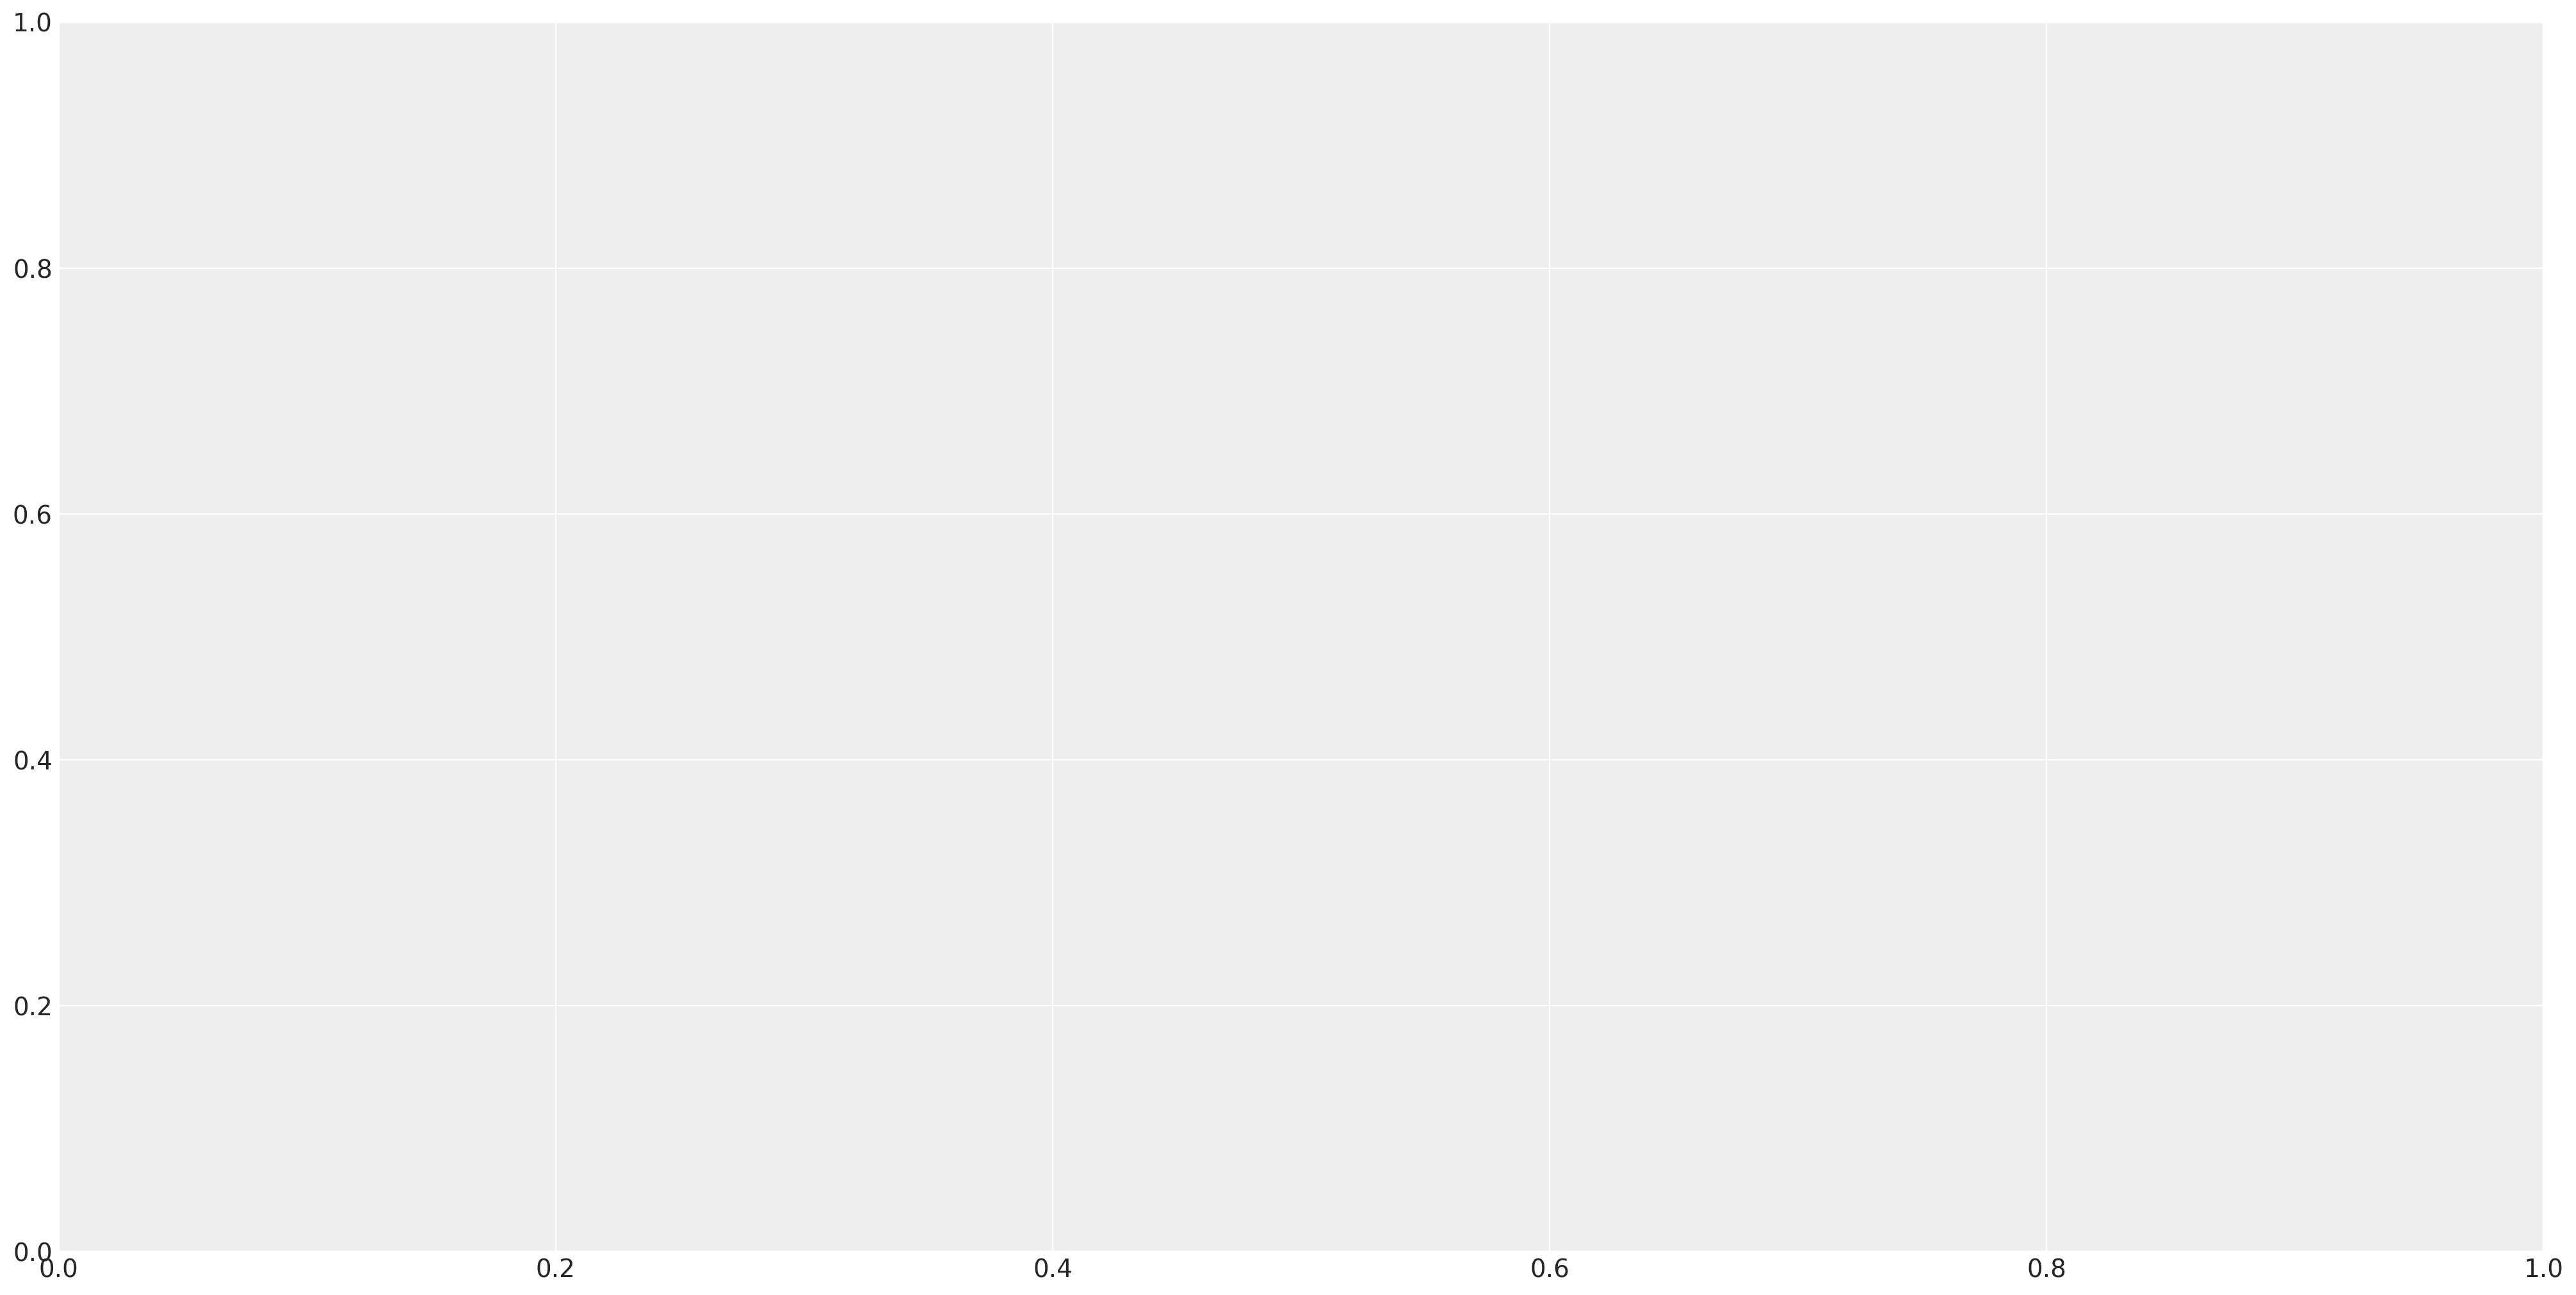

In [263]:
mask = data['Epidemiological Days'] >= 0

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X, post_Pred["cases"].T, color="k", alpha=0.05)
ax.plot(X, data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual")
# ax.set_yscale("log")
ax.set(xlabel="Days Since 100 Cases", ylabel="Weekly Rolling Average", title="Daily Cumulative Count of Cases")
ax.legend()
# plt.show()

In [87]:
# Update data reference.
pm.set_data({"X": X_forecast}, model=model)
# Generate posterior samples.
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [88]:
forecast_std = np.std(ppc_test["cases"].T, axis=1)

/home/vscode/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


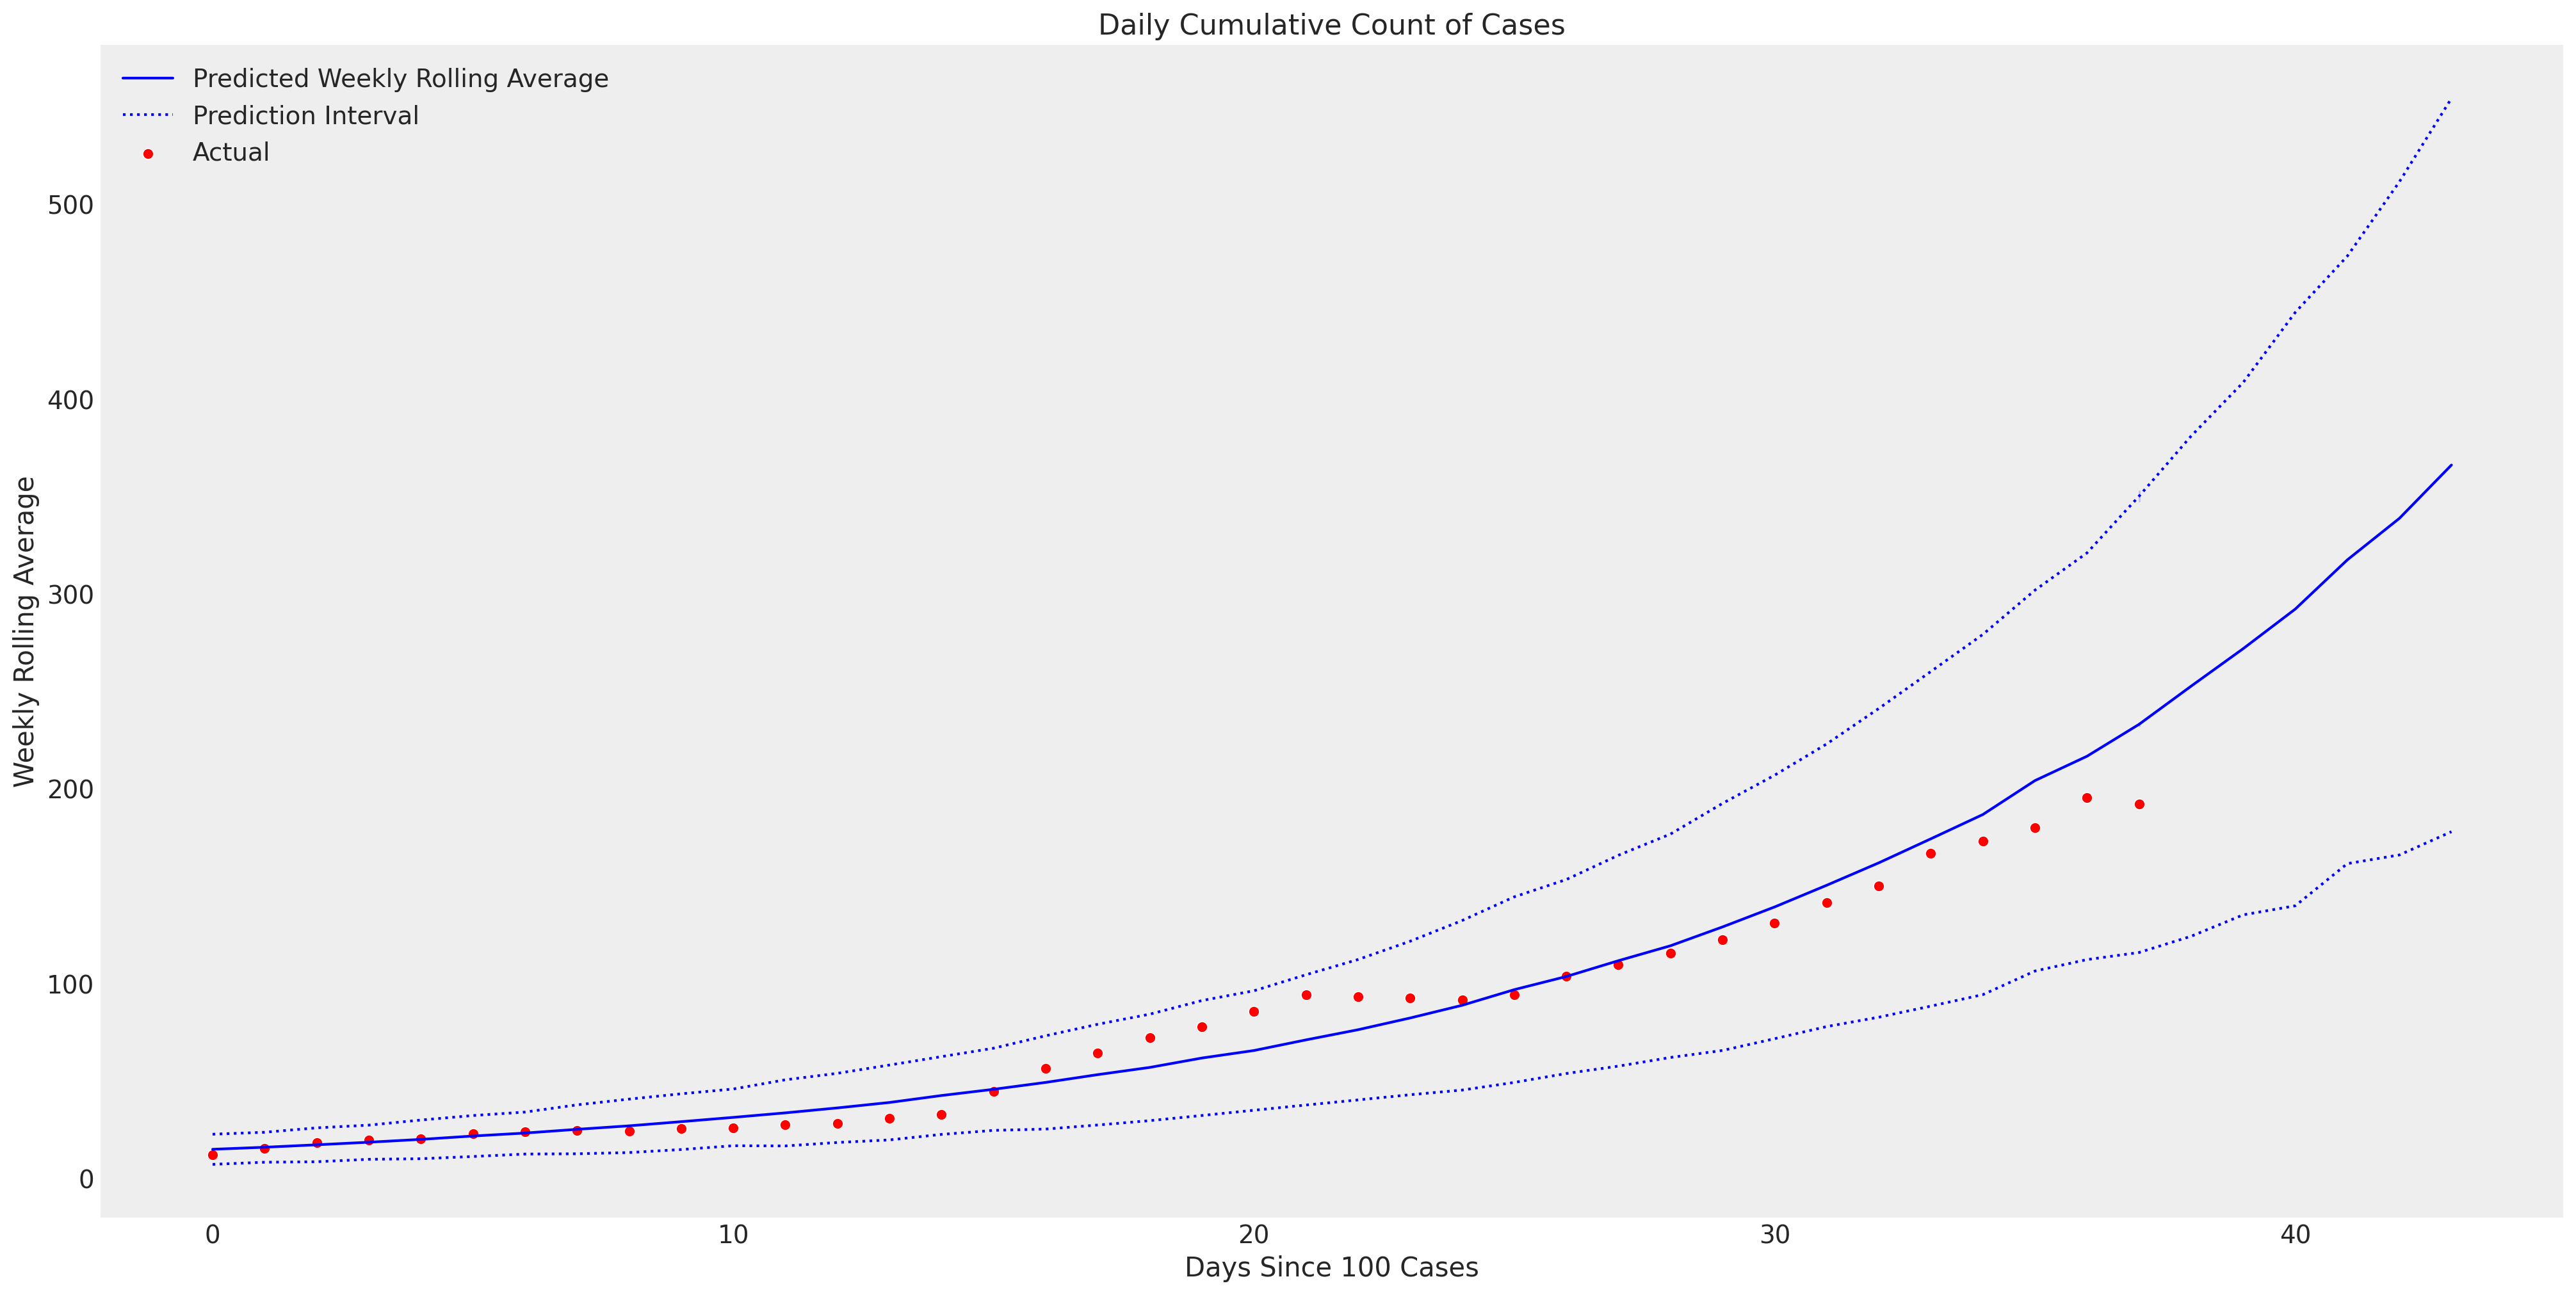

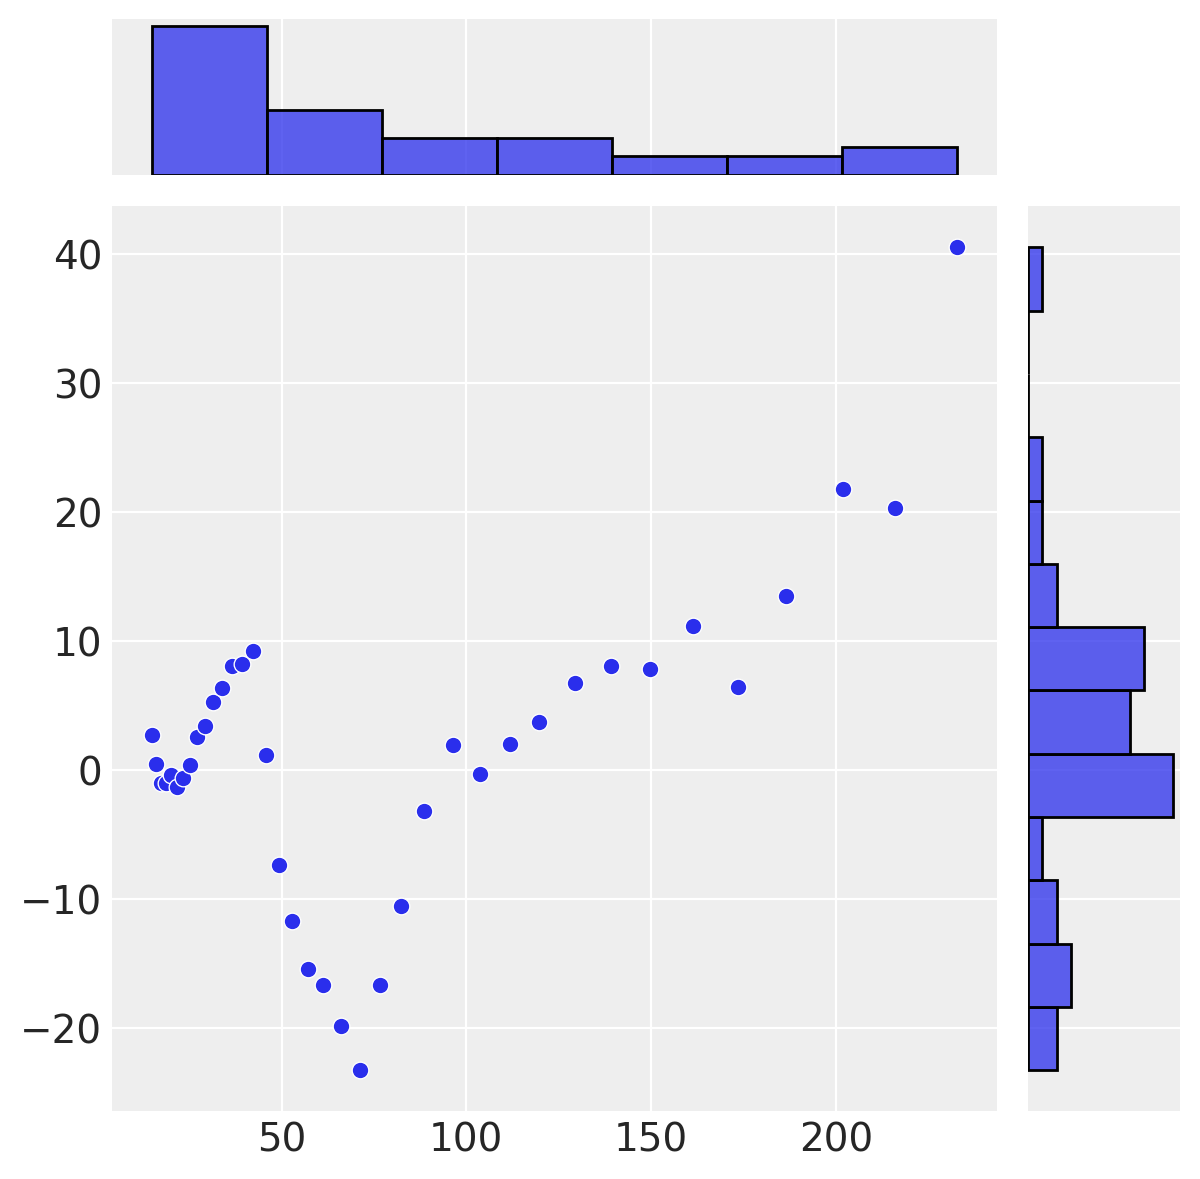

In [104]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=X_forecast, y=np.mean(ppc_test["cases"].T, axis=1), color="b", label="Predicted Weekly Rolling Average", ax=ax)
ax = sns.lineplot(x=X_forecast, y=np.mean(ppc_test["cases"].T, axis=1) + 3*forecast_std, color="b", linestyle=":", label="Prediction Interval", ax=ax)
ax = sns.lineplot(x=X_forecast, y=np.mean(ppc_test["cases"].T, axis=1) - 3*forecast_std, color="b", linestyle=":", ax=ax)
ax = sns.scatterplot(x=data.loc[mask, "Epidemiological Days"], y=data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual", ax=ax)

ax.set(xlabel="Days Since 100 Cases", ylabel="Weekly Rolling Average", title="Daily Cumulative Count of Cases")
ax.legend()
ax.grid()

# Residual Plotting
ax = sns.jointplot(x=np.mean(post_Pred["cases"].T, axis=1), y=(np.mean(post_Pred["cases"].T, axis=1)-y), ax=ax, marker="o")
# ax.set(title="Relative Residual plotting")

In [ ]:
mask = data['Epidemiological Days'] >= 0
daily_number_of_cases_std = data.loc[mask, 'Daily Number of Cases'].std()
average_growth_factor = data.loc[mask, 'Growth Factor'].mean()
std_growth_factor = data.loc[mask, 'Growth Factor'].std()


forecast_ndays = 7
X_forecast = np.append(X, list(np.arange(X.max(), X.max() + forecast_ndays)))

In [105]:
mask = data["Epidemiological Days"] >= 0
data_forecast = pd.DataFrame({"Epidemiological Days": X_forecast
                            ,"Predicted Weekly Rolling Average": np.mean(ppc_test["cases"].T, axis=1)
                            ,"notification_date": data.loc[mask, "notification_date"].append(pd.Series([data["notification_date"].max() + timedelta(days=day) for day in range(forecast_ndays)]))
                            ,"Predicted Weekly Rolling Std": np.std(ppc_test["cases"].T, axis=1)
                            })
data_forecast.reset_index(inplace=True, drop=True)
data_forecast["Prediction Lower Bound"] = data_forecast["Predicted Weekly Rolling Average"] - 3*data_forecast["Predicted Weekly Rolling Std"]
data_forecast["Prediction Upper Bound"] = data_forecast["Predicted Weekly Rolling Average"] + 3*data_forecast["Predicted Weekly Rolling Std"]
data_forecast

,Epidemiological Days,Predicted Weekly Rolling Average,notification_date,Predicted Weekly Rolling Std,Prediction Lower Bound,Prediction Upper Bound
0,0.0,15.128235,2021-06-25,2.577005,7.397221,22.859249
1,1.0,16.174286,2021-06-26,2.563784,8.482935,23.865637
2,2.0,17.434299,2021-06-27,2.899601,8.735496,26.133102
3,3.0,18.752891,2021-06-28,2.921781,9.987548,27.518234
4,4.0,20.211534,2021-06-29,3.308529,10.285946,30.137122
5,5.0,21.937732,2021-06-30,3.504282,11.424887,32.450576
6,6.0,23.453883,2021-07-01,3.589857,12.684312,34.223455
7,7.0,25.377232,2021-07-02,4.184104,12.824920,37.929543
8,8.0,27.166905,2021-07-03,4.572524,13.449332,40.884478
9,9.0,29.302615,2021-07-04,4.768827,14.996135,43.609096


In [190]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 03 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.25.0

numpy     : 1.19.5
arviz     : 0.11.2
pandas    : 1.3.0
sys       : 3.9.2 (default, Mar 12 2021, 19:04:51) 
[GCC 8.3.0]
matplotlib: 3.4.2
pymc3     : 3.11.2
seaborn   : 0.11.1

Watermark: 2.2.0

